# BaseLine Transformer model

Caution: This is not a usual use case of Transformer.

Transformer developed by Google usually use Embeddeding Layer to represents a target such as a word.

In this model, I use OHLC as a state vector though we can take same approch for finance data.
As d_model is very low, this would be a base line of Transformer.

Parameters:
- Input:  ohlc_df.iloc[index] while observation length
- Target: ohlc_df.iloc[index+observation_length] while prediction length

## Data Preparation

Since we shouldn't expose data obtained from other service, csv is not committed to this repository.
Please preprare your data and load it.

In [2]:
import os
ohlc_column = ('open','high','low','close')
file_path = os.path.abspath('../Data/mt5_USDJPY_min30.csv')

In [3]:
import pandas as pd
df = pd.read_csv(file_path)
df

,time,open,high,low,close,tick_volume,spread,real_volume
0,2014-07-07 08:30:00,102.086,102.122,102.081,102.102,738,3,0
1,2014-07-07 09:00:00,102.102,102.146,102.098,102.113,1036,3,0
2,2014-07-07 09:30:00,102.113,102.115,102.042,102.044,865,3,0
3,2014-07-07 10:00:00,102.047,102.052,102.005,102.019,983,3,0
4,2014-07-07 10:30:00,102.017,102.025,101.918,101.941,1328,3,0
...,...,...,...,...,...,...,...,...
100715,2022-08-12 21:30:00,133.461,133.506,133.439,133.484,1125,3,0
100716,2022-08-12 22:00:00,133.484,133.530,133.437,133.475,1277,3,0
100717,2022-08-12 22:30:00,133.475,133.486,133.433,133.483,1506,3,0
100718,2022-08-12 23:00:00,133.484,133.536,133.465,133.521,1038,3,0


## Basic Dataset Definition

In [4]:
import math
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import (TransformerDecoder, TransformerDecoderLayer,
                      TransformerEncoder, TransformerEncoderLayer)
from torch.utils.data import DataLoader
from tqdm import tqdm

In [5]:
class Dataset:
    version = 8

    def __init__(
        self, df, ohlc_columns, volume_columns=[], observation_length: int = 30,
        device="cuda", init_type="log", future_step_size=1, seed=1017, is_training=True, randomize=True
    ):
        self.seed(seed)
        self.mm_params = {}
        ohlc_df = self._init_ohlc(df, ohlc_columns, init_type)

        if len(volume_columns) > 0:
            volume_df = self._init_volume(df, volume_columns)
            data = pd.concat([ohlc_df, volume_df], axis=1)
        else:
            data = ohlc_df

        self.observation_length = observation_length
        self.is_training = is_training
        self.device = device
        self._data = data
        self._columns = data.columns
        self._future_step_size = future_step_size
        self._init_indicies(data, randomize)

    def _init_ohlc(self, df, columns, init_type="log"):
        ohlc_df = df[columns]
        ohlc_df = ohlc_df.apply(np.log).diff()
        if init_type == "cumsum":
            ohlc_df = ohlc_df.cumsum()
        # added from v7 because position is high value compared with diff value
        scale = (-1, 1)
        min_series = ohlc_df.min()
        max_series = ohlc_df.max()
        self.mm_params["ohlc"] = (min_series, max_series)
        std = (ohlc_df - min_series) / (max_series - min_series)
        ohlc_df = std * (scale[1] - scale[0]) + scale[0]
        
        return ohlc_df

    def _init_volume(self, df, columns):
        volume_df = df[columns]
        scale = (-1, 1)
        min_series = volume_df.min()
        max_series = volume_df.max()
        self.mm_params["volume"] = (min_series, max_series)
        std = (volume_df - min_series) / (max_series - min_series)
        volume_df = std * (scale[1] - scale[0]) + scale[0]
        return volume_df

    def _init_indicies(self, data, randomize=False, split_ratio=0.7):
        length = len(data) - self.observation_length - self._future_step_size
        if length <= 0:
            raise Exception(f"date length {length} is less than observation_length {self.observation_length}")

        # stopped from v7. As input data inluceds target data
        # indices = random.sample(range(1, length), k=length-1)

        from_index = 1
        to_index = int(length * split_ratio)
        train_indices = list(range(from_index, to_index))
        if randomize:
            self.train_indices = random.sample(train_indices, k=to_index - from_index)
        else:
            self.train_indices = train_indices

        # Note: If unique value exits in validation data only, validation loss would be grater than expected
        from_index = int(length * split_ratio) + self.observation_length + self._future_step_size
        to_index = length
        eval_indices = list(range(from_index, to_index))
        if randomize:
            self.eval_indices = random.sample(eval_indices, k=to_index - from_index)
        else:
            self.eval_indices = eval_indices

        if self.is_training:
            self._indices = self.train_indices
        else:
            self._indices = self.eval_indices

    def _output_func(self, batch_size):
        if type(batch_size) == int:
            index = self._indices[batch_size]
            ans = self._data[index + self.observation_length - 1 : index + self.observation_length + self._future_step_size].T.values.tolist()
            ans = torch.tensor(ans, device=self.device, dtype=torch.float)
            ans = ans.reshape(len(self._columns), 1, self._future_step_size + 1)
            return ans.transpose(0, 2)
        elif type(batch_size) == slice:
            batch_indices = batch_size
            chunk_data = []
            for column in self._columns:
                column_chunk = []
                for index in self._indices[batch_indices]:
                    column_chunk.append(
                        self._data[column][
                            index + self.observation_length - 1 : index + self.observation_length + self._future_step_size
                        ].values.tolist()
                    )
                chunk_data.append(column_chunk)

            return torch.tensor(chunk_data, device=self.device, dtype=torch.float).transpose(0, 2)

    def _input_func(self, batch_size):
        if type(batch_size) == int:
            index = self._indices[batch_size]
            src = self._data[index : index + self.observation_length].T.values.tolist()
            src = torch.tensor(src, device=self.device, dtype=torch.float)
            src = src.reshape(len(self._columns), 1, self.observation_length)
            return src.transpose(0, 2)
        elif type(batch_size) == slice:
            batch_indices = batch_size
            chunk_src = []
            for column in self._columns:
                column_chunk_src = []
                for index in self._indices[batch_indices]:
                    column_chunk_src.append(self._data[column][index : index + self.observation_length].values.tolist())
                chunk_src.append(column_chunk_src)

            return torch.tensor(chunk_src, device=self.device, dtype=torch.float).transpose(0, 2)

    def __len__(self):
        return len(self._indices)

    def __getitem__(self, ndx):
        return self._input_func(ndx), self._output_func(ndx)

    def seed(self, seed=None):
        """ """
        if seed is None:
            seed = 1192
        else:
            torch.backends.cudnn.benchmark = False
            torch.backends.cudnn.deterministic = True
        torch.manual_seed(seed)
        random.seed(seed)
        np.random.seed(seed)
        self.seed_value = seed

    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)

    def render(self, mode="human", close=False):
        """ """
        pass

    def eval(self):
        self._indices = self.eval_indices
        self.is_training = False

    def train(self):
        self._indices = self.train_indices
        self.is_training = True

    def get_actual_index(self, ndx):
        inputs = []
        if type(ndx) == slice:
            for index in self._indices[ndx]:
                inputs.append(index)
        else:
            inputs = self._indices[ndx]
        return inputs

    def get_row_data(self, ndx):
        inputs = []
        if type(ndx) == slice:
            for index in self._indices[ndx]:
                df = self._data[index : index + self.observation_length]
                inputs.append(df)
        else:
            index = ndx
            inputs = df = self._data[index : index + self.observation_length]
        return inputs

## Define Model

In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=0.05):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(-2)
        #pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, src, tgt):
        src_pos = src.size(0)
        tgt_pos = src_pos + tgt.size(0) - 1
        return self.dropout(src + self.pe[:src_pos, :]), self.dropout(tgt + self.pe[src_pos-1:tgt_pos, :])

In [7]:
class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        feature_size: int,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):
        
        super(Seq2SeqTransformer, self).__init__()

        self.positional_encoding = PositionalEncoding(feature_size, dropout=dropout)
        
        encoder_layer = TransformerEncoderLayer(
            d_model=feature_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        decoder_layer = TransformerDecoderLayer(
            d_model=feature_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

    def forward(
        self, src: Tensor, tgt: Tensor, mask_tgt: Tensor,
        mask_src: Tensor=None, padding_mask_src: Tensor=None, padding_mask_tgt: Tensor=None,
        memory_key_padding_mask: Tensor=None
    ):
        
        src, tgt = self.positional_encoding(src, tgt)
        memory = self.transformer_encoder(src, mask_src, padding_mask_src)
        outs = self.transformer_decoder(
            tgt, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        return outs

## Define Training Methods

In [14]:
def train(model, ds, optimizer, criterion, batch_size, device):
    
    model.train()
    ds.train()
    losses = 0
    
    length = 0.0
    end_index = len(ds)
    for index in tqdm(range(0, end_index, batch_size)):
        if end_index - index < batch_size:
            break
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        src = src.to(device)
        tgt = tgt.to(device)

        input_tgt = tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
        logits = model(
            src=src, tgt=input_tgt,  mask_tgt=mask_tgt
        )

        optimizer.zero_grad()

        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / length

In [15]:
def evaluate(model, ds, criterion, batch_size, device):
    
    model.eval()
    ds.eval()
    losses = 0
    length = 0.0
    for index in range(0, len(ds), batch_size):
        if len(ds) - index < batch_size:
            break
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        src = src.to(device)
        tgt = tgt.to(device)

        input_tgt = tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)

        logits = model(
            src=src, tgt=input_tgt, mask_tgt=mask_tgt,
        )
        
        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        losses += loss.item()
        
    return losses / length

## Training

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_name = "finance_basic_transfomer"
model_version = "v1"

#Dataset parameters
standalization = "log"
batch_size = 64
observation_length = 30
prediction_length = 10
columns = ["open", "high", "low", "close"]
volume_columns = ["tick_volume", "spread"]

ds = Dataset(df, columns, volume_columns, observation_length, device, standalization, prediction_length)

In [49]:
# check outputs represents (data_length, chunk_size, feature_size)
ds.train()
for index in range(0, len(ds)-16, 16):
    src, tgt = ds[index: index+16]
    continue
print(src.shape, tgt.shape)

torch.Size([30, 16, 6]) torch.Size([11, 16, 6])


In [9]:
feature_size = 6

# Hyper parameters
nhead = 1
dim_feedforward = 1000
num_encoder_layers = 6
num_decoder_layers = 6
dropout = 0.01

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    feature_size=feature_size,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

In [10]:
lr = 0.00005

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.95)

In [53]:
epoch = 500
best_loss = float('Inf')
best_model = None
patience = 10
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds=ds, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size,
        device=device
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,
        batch_size=batch_size, device=device
    )
    
    print('[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    ))
    
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
    else:
        counter += 1
        scheduler.step()
        
    if counter > patience:
        break

100%|█████████▉| 1101/1102 [02:17<00:00,  7.98it/s]


[1/500] train loss: 0.1999668968, valid loss: 0.1447812436  18s] count: 0, **


100%|█████████▉| 1101/1102 [02:14<00:00,  8.19it/s]


[2/500] train loss: 0.1136597093, valid loss: 0.0851220058  14s] count: 0, **


100%|█████████▉| 1101/1102 [02:30<00:00,  7.31it/s]


[3/500] train loss: 0.0635748387, valid loss: 0.0451294458  31s] count: 0, **


100%|█████████▉| 1101/1102 [02:29<00:00,  7.38it/s]


[4/500] train loss: 0.0316196207, valid loss: 0.0212085399  29s] count: 0, **


100%|█████████▉| 1101/1102 [02:40<00:00,  6.88it/s]


[5/500] train loss: 0.0136495252, valid loss: 0.0090157450  40s] count: 0, **


100%|█████████▉| 1101/1102 [02:45<00:00,  6.67it/s]


[6/500] train loss: 0.0053406032, valid loss: 0.0041891087  45s] count: 0, **


100%|█████████▉| 1101/1102 [02:06<00:00,  8.73it/s]


[7/500] train loss: 0.0024859769, valid loss: 0.0029547394  6s] count: 0, **


100%|█████████▉| 1101/1102 [02:10<00:00,  8.45it/s]


[8/500] train loss: 0.0018832303, valid loss: 0.0028121986  10s] count: 0, **


100%|█████████▉| 1101/1102 [02:10<00:00,  8.45it/s]


[9/500] train loss: 0.0018036390, valid loss: 0.0027948536  10s] count: 0, **


100%|█████████▉| 1101/1102 [02:17<00:00,  8.00it/s]


[10/500] train loss: 0.0017724126, valid loss: 0.0027831725  18s] count: 0, **


100%|█████████▉| 1101/1102 [02:11<00:00,  8.35it/s]


[11/500] train loss: 0.0017344298, valid loss: 0.0027594794  12s] count: 0, **


100%|█████████▉| 1101/1102 [02:05<00:00,  8.80it/s]


[12/500] train loss: 0.0016881497, valid loss: 0.0026225630  5s] count: 0, **


100%|█████████▉| 1101/1102 [02:11<00:00,  8.36it/s]


[13/500] train loss: 0.0016583300, valid loss: 0.0025550268  12s] count: 0, **


100%|█████████▉| 1101/1102 [02:17<00:00,  8.00it/s]


[14/500] train loss: 0.0016259116, valid loss: 0.0025101748  18s] count: 0, **


100%|█████████▉| 1101/1102 [02:21<00:00,  7.79it/s]


[15/500] train loss: 0.0016012022, valid loss: 0.0024784757  21s] count: 0, **


100%|█████████▉| 1101/1102 [02:11<00:00,  8.36it/s]


[16/500] train loss: 0.0015720572, valid loss: 0.0024139953  12s] count: 0, **


100%|█████████▉| 1101/1102 [02:08<00:00,  8.59it/s]


[17/500] train loss: 0.0015448301, valid loss: 0.0023951966  8s] count: 0, **


100%|█████████▉| 1101/1102 [02:13<00:00,  8.24it/s]


[18/500] train loss: 0.0015242261, valid loss: 0.0023567737  14s] count: 0, **


100%|█████████▉| 1101/1102 [02:14<00:00,  8.21it/s]


[19/500] train loss: 0.0015085088, valid loss: 0.0023478882  14s] count: 0, **


100%|█████████▉| 1101/1102 [02:04<00:00,  8.84it/s]


[20/500] train loss: 0.0014866710, valid loss: 0.0023447817  5s] count: 0, **


100%|█████████▉| 1101/1102 [02:19<00:00,  7.92it/s]


[21/500] train loss: 0.0014702350, valid loss: 0.0022959026  19s] count: 0, **


100%|█████████▉| 1101/1102 [02:35<00:00,  7.08it/s]


[22/500] train loss: 0.0014550712, valid loss: 0.0023192186  36s] count: 0, 


100%|█████████▉| 1101/1102 [02:31<00:00,  7.25it/s]


[23/500] train loss: 0.0014398931, valid loss: 0.0023128826  32s] count: 1, 


100%|█████████▉| 1101/1102 [02:23<00:00,  7.66it/s]


[24/500] train loss: 0.0014264995, valid loss: 0.0022855305  24s] count: 2, **


100%|█████████▉| 1101/1102 [02:17<00:00,  8.00it/s]


[25/500] train loss: 0.0014164841, valid loss: 0.0022656797  18s] count: 0, **


100%|█████████▉| 1101/1102 [02:14<00:00,  8.21it/s]


[26/500] train loss: 0.0014047819, valid loss: 0.0022710283  14s] count: 0, 


100%|█████████▉| 1101/1102 [01:59<00:00,  9.19it/s]


[27/500] train loss: 0.0013951345, valid loss: 0.0022977102  60s] count: 1, 


100%|█████████▉| 1101/1102 [02:05<00:00,  8.79it/s]


[28/500] train loss: 0.0013868060, valid loss: 0.0023023257  5s] count: 2, 


100%|█████████▉| 1101/1102 [02:11<00:00,  8.37it/s]


[29/500] train loss: 0.0013778896, valid loss: 0.0022808569  12s] count: 3, 


100%|█████████▉| 1101/1102 [02:16<00:00,  8.04it/s]


[30/500] train loss: 0.0013674880, valid loss: 0.0023050982  17s] count: 4, 


100%|█████████▉| 1101/1102 [02:31<00:00,  7.28it/s]


[31/500] train loss: 0.0013621621, valid loss: 0.0022581393  31s] count: 5, **


100%|█████████▉| 1101/1102 [02:39<00:00,  6.89it/s]


[32/500] train loss: 0.0013554407, valid loss: 0.0022559555  40s] count: 0, **


100%|█████████▉| 1101/1102 [02:44<00:00,  6.68it/s]


[33/500] train loss: 0.0013516211, valid loss: 0.0022885259  45s] count: 0, 


100%|█████████▉| 1101/1102 [02:47<00:00,  6.56it/s]


[34/500] train loss: 0.0013440475, valid loss: 0.0022576060  48s] count: 1, 


100%|█████████▉| 1101/1102 [02:24<00:00,  7.61it/s]


[35/500] train loss: 0.0013389510, valid loss: 0.0022536913  25s] count: 2, **


100%|█████████▉| 1101/1102 [02:32<00:00,  7.22it/s]


[36/500] train loss: 0.0013350966, valid loss: 0.0022166321  32s] count: 0, **


100%|█████████▉| 1101/1102 [02:25<00:00,  7.58it/s]


[37/500] train loss: 0.0013299625, valid loss: 0.0022182785  25s] count: 0, 


100%|█████████▉| 1101/1102 [02:06<00:00,  8.73it/s]


[38/500] train loss: 0.0013260002, valid loss: 0.0022091626  6s] count: 1, **


100%|█████████▉| 1101/1102 [02:11<00:00,  8.34it/s]


[39/500] train loss: 0.0013203494, valid loss: 0.0021864212  12s] count: 0, **


100%|█████████▉| 1101/1102 [02:10<00:00,  8.41it/s]


[40/500] train loss: 0.0013184969, valid loss: 0.0022178033  11s] count: 0, 


100%|█████████▉| 1101/1102 [02:08<00:00,  8.57it/s]


[41/500] train loss: 0.0013129261, valid loss: 0.0021903000  8s] count: 1, 


100%|█████████▉| 1101/1102 [02:20<00:00,  7.84it/s]


[42/500] train loss: 0.0013099277, valid loss: 0.0021936667  20s] count: 2, 


100%|█████████▉| 1101/1102 [02:06<00:00,  8.70it/s]


[43/500] train loss: 0.0013062905, valid loss: 0.0021764646  7s] count: 3, **


100%|█████████▉| 1101/1102 [02:06<00:00,  8.71it/s]


[44/500] train loss: 0.0013024542, valid loss: 0.0021864278  6s] count: 0, 


100%|█████████▉| 1101/1102 [02:07<00:00,  8.65it/s]


[45/500] train loss: 0.0013003394, valid loss: 0.0022020870  7s] count: 1, 


100%|█████████▉| 1101/1102 [02:10<00:00,  8.45it/s]


[46/500] train loss: 0.0012982331, valid loss: 0.0021837667  10s] count: 2, 


100%|█████████▉| 1101/1102 [02:12<00:00,  8.29it/s]


[47/500] train loss: 0.0012939036, valid loss: 0.0021869398  13s] count: 3, 


100%|█████████▉| 1101/1102 [02:10<00:00,  8.43it/s]


[48/500] train loss: 0.0012918521, valid loss: 0.0021942933  11s] count: 4, 


100%|█████████▉| 1101/1102 [02:19<00:00,  7.90it/s]


[49/500] train loss: 0.0012904135, valid loss: 0.0021838671  19s] count: 5, 


100%|█████████▉| 1101/1102 [02:17<00:00,  7.98it/s]


[50/500] train loss: 0.0012872426, valid loss: 0.0021862180  18s] count: 6, 


100%|█████████▉| 1101/1102 [02:18<00:00,  7.94it/s]


[51/500] train loss: 0.0012853420, valid loss: 0.0021836639  19s] count: 7, 


100%|█████████▉| 1101/1102 [02:18<00:00,  7.94it/s]


[52/500] train loss: 0.0012846360, valid loss: 0.0021625696  19s] count: 8, **


100%|█████████▉| 1101/1102 [02:17<00:00,  8.03it/s]


[53/500] train loss: 0.0012812206, valid loss: 0.0021878845  17s] count: 0, 


100%|█████████▉| 1101/1102 [02:17<00:00,  8.02it/s]


[54/500] train loss: 0.0012796714, valid loss: 0.0021593661  17s] count: 1, **


100%|█████████▉| 1101/1102 [02:11<00:00,  8.35it/s]


[55/500] train loss: 0.0012766672, valid loss: 0.0021804021  12s] count: 0, 


100%|█████████▉| 1101/1102 [02:13<00:00,  8.24it/s]


[56/500] train loss: 0.0012746376, valid loss: 0.0021652996  14s] count: 1, 


100%|█████████▉| 1101/1102 [02:18<00:00,  7.96it/s]


[57/500] train loss: 0.0012733801, valid loss: 0.0021531887  18s] count: 2, **


100%|█████████▉| 1101/1102 [02:18<00:00,  7.97it/s]


[58/500] train loss: 0.0012728423, valid loss: 0.0021572183  18s] count: 0, 


100%|█████████▉| 1101/1102 [02:20<00:00,  7.83it/s]


[59/500] train loss: 0.0012715053, valid loss: 0.0021597145  21s] count: 1, 


100%|█████████▉| 1101/1102 [02:13<00:00,  8.23it/s]


[60/500] train loss: 0.0012700832, valid loss: 0.0021550144  14s] count: 2, 


100%|█████████▉| 1101/1102 [02:04<00:00,  8.86it/s]


[61/500] train loss: 0.0012682462, valid loss: 0.0021743711  4s] count: 3, 


100%|█████████▉| 1101/1102 [02:14<00:00,  8.16it/s]


[62/500] train loss: 0.0012669319, valid loss: 0.0021669503  15s] count: 4, 


100%|█████████▉| 1101/1102 [02:31<00:00,  7.28it/s]


[63/500] train loss: 0.0012653570, valid loss: 0.0021502116  31s] count: 5, **


100%|█████████▉| 1101/1102 [02:53<00:00,  6.35it/s]


[64/500] train loss: 0.0012637970, valid loss: 0.0021369616  53s] count: 0, **


100%|█████████▉| 1101/1102 [02:41<00:00,  6.81it/s]


[65/500] train loss: 0.0012630339, valid loss: 0.0021462037  42s] count: 0, 


100%|█████████▉| 1101/1102 [02:37<00:00,  7.00it/s]


[66/500] train loss: 0.0012629658, valid loss: 0.0021349538  37s] count: 1, **


100%|█████████▉| 1101/1102 [02:36<00:00,  7.06it/s]


[67/500] train loss: 0.0012626019, valid loss: 0.0021395151  36s] count: 0, 


100%|█████████▉| 1101/1102 [02:31<00:00,  7.29it/s]


[68/500] train loss: 0.0012602398, valid loss: 0.0021376975  31s] count: 1, 


100%|█████████▉| 1101/1102 [02:44<00:00,  6.68it/s]


[69/500] train loss: 0.0012603342, valid loss: 0.0021512732  45s] count: 2, 


100%|█████████▉| 1101/1102 [02:45<00:00,  6.65it/s]


[70/500] train loss: 0.0012575033, valid loss: 0.0021332223  46s] count: 3, **


100%|█████████▉| 1101/1102 [02:24<00:00,  7.60it/s]


[71/500] train loss: 0.0012571790, valid loss: 0.0021452296  25s] count: 0, 


100%|█████████▉| 1101/1102 [02:33<00:00,  7.16it/s]


[72/500] train loss: 0.0012573379, valid loss: 0.0021238110  34s] count: 1, **


100%|█████████▉| 1101/1102 [02:29<00:00,  7.35it/s]


[73/500] train loss: 0.0012566253, valid loss: 0.0021372180  30s] count: 0, 


100%|█████████▉| 1101/1102 [02:42<00:00,  6.75it/s]


[74/500] train loss: 0.0012539815, valid loss: 0.0021332653  43s] count: 1, 


100%|█████████▉| 1101/1102 [02:33<00:00,  7.18it/s]


[75/500] train loss: 0.0012555245, valid loss: 0.0021416270  33s] count: 2, 


100%|█████████▉| 1101/1102 [02:34<00:00,  7.14it/s]


[76/500] train loss: 0.0012540787, valid loss: 0.0021362762  34s] count: 3, 


100%|█████████▉| 1101/1102 [02:37<00:00,  6.98it/s]


[77/500] train loss: 0.0012523793, valid loss: 0.0021336077  38s] count: 4, 


100%|█████████▉| 1101/1102 [02:35<00:00,  7.10it/s]


[78/500] train loss: 0.0012509850, valid loss: 0.0021199683  35s] count: 5, **


100%|█████████▉| 1101/1102 [02:19<00:00,  7.92it/s]


[79/500] train loss: 0.0012503271, valid loss: 0.0021382680  19s] count: 0, 


100%|█████████▉| 1101/1102 [02:23<00:00,  7.66it/s]


[80/500] train loss: 0.0012511285, valid loss: 0.0021322448  24s] count: 1, 


100%|█████████▉| 1101/1102 [02:16<00:00,  8.04it/s]


[81/500] train loss: 0.0012494010, valid loss: 0.0021269597  17s] count: 2, 


100%|█████████▉| 1101/1102 [02:16<00:00,  8.06it/s]


[82/500] train loss: 0.0012498455, valid loss: 0.0021277112  17s] count: 3, 


100%|█████████▉| 1101/1102 [02:17<00:00,  8.00it/s]


[83/500] train loss: 0.0012492248, valid loss: 0.0021299123  18s] count: 4, 


100%|█████████▉| 1101/1102 [02:26<00:00,  7.49it/s]


[84/500] train loss: 0.0012485887, valid loss: 0.0021259650  27s] count: 5, 


100%|█████████▉| 1101/1102 [02:23<00:00,  7.69it/s]


[85/500] train loss: 0.0012475101, valid loss: 0.0021276660  23s] count: 6, 


100%|█████████▉| 1101/1102 [02:18<00:00,  7.98it/s]


[86/500] train loss: 0.0012466358, valid loss: 0.0021169836  18s] count: 7, **


100%|█████████▉| 1101/1102 [02:16<00:00,  8.05it/s]


[87/500] train loss: 0.0012458766, valid loss: 0.0021267209  17s] count: 0, 


100%|█████████▉| 1101/1102 [02:22<00:00,  7.72it/s]


[88/500] train loss: 0.0012464811, valid loss: 0.0021328858  23s] count: 1, 


100%|█████████▉| 1101/1102 [02:23<00:00,  7.67it/s]


[89/500] train loss: 0.0012469410, valid loss: 0.0021297238  24s] count: 2, 


100%|█████████▉| 1101/1102 [02:18<00:00,  7.96it/s]


[90/500] train loss: 0.0012462696, valid loss: 0.0021249136  18s] count: 3, 


100%|█████████▉| 1101/1102 [02:16<00:00,  8.06it/s]


[91/500] train loss: 0.0012454649, valid loss: 0.0021222063  17s] count: 4, 


100%|█████████▉| 1101/1102 [02:22<00:00,  7.71it/s]


[92/500] train loss: 0.0012451459, valid loss: 0.0021206338  23s] count: 5, 


100%|█████████▉| 1101/1102 [02:23<00:00,  7.69it/s]


[93/500] train loss: 0.0012448280, valid loss: 0.0021271494  23s] count: 6, 


100%|█████████▉| 1101/1102 [02:17<00:00,  8.01it/s]


[94/500] train loss: 0.0012451430, valid loss: 0.0021170941  17s] count: 7, 


100%|█████████▉| 1101/1102 [02:17<00:00,  8.02it/s]


[95/500] train loss: 0.0012447868, valid loss: 0.0021253095  17s] count: 8, 


100%|█████████▉| 1101/1102 [02:23<00:00,  7.68it/s]


[96/500] train loss: 0.0012436348, valid loss: 0.0021226994  23s] count: 9, 


100%|█████████▉| 1101/1102 [02:23<00:00,  7.70it/s]


[97/500] train loss: 0.0012435847, valid loss: 0.0021203667  23s] count: 10, 


In [54]:
torch.save(best_model.state_dict(), f'./{model_name}_v{model_version}.torch')

## Validation

In [11]:
model_version = 3
model.load_state_dict(torch.load(f'./{model_name}_v{model_version}.torch'))

<All keys matched successfully>

In [12]:
def prediction(inputs):

    preds = torch.zeros(1, inputs.size(1), feature_size, device=device)
    preds[0, :, :] = inputs[-1,:, :]
    while preds.size(0) <= prediction_length:
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(preds.size(0)).to(device)
        out = model(src=inputs, tgt=preds,  mask_tgt=tgt_mask)
        preds = torch.cat([preds, out[-1:]], dim=0)
    return preds

In [13]:
src, tgt = ds[:16]

In [14]:
tgt_values = tgt.cpu().detach().numpy()
tgt_values.shape

(11, 16, 6)

In [15]:
target_columns = columns# + volume_columns
ohlc_min, ohlc_max = ds.mm_params["ohlc"]
# volume_min, volume_max = ds.mm_params["volume"]
# std_min = pd.concat([ohlc_min, volume_min])
# std_max = pd.concat([ohlc_max, volume_max])
std_min = ohlc_min.values.reshape(1, 1, len(target_columns))
std_max = ohlc_max.values.reshape(1, 1, len(target_columns))

In [16]:
def revert_minmax(values, scale=(-1, 1)):
    std = (values - scale[0])/(scale[1] - scale[0])
    value = std * (std_max - std_min) + std_min
    return value

In [17]:
def revert_target(tgt_values, ndx: slice):
    log_diff_values = revert_minmax(tgt_values[:,:,:4])
    log_cumsum_values = np.cumsum(log_diff_values, axis=0)
    idx = ds.get_actual_index(ndx)
    # -1 for shift, -1 for diff
    idx = [index + observation_length -2 for index in idx]
    start_values = df.iloc[idx][target_columns].values
    start_values = np.log(start_values)
    return np.exp(start_values + log_cumsum_values)

In [18]:
revert_target(tgt_values, slice(0, 16))[:6, 0, :]

array([[106.25100002, 106.28500011, 106.21799995, 106.26299998],
       [106.26399997, 106.2840001 , 106.24800007, 106.27299992],
       [106.27300002, 106.2830001 , 106.20700013, 106.20799987],
       [106.20600011, 106.24100012, 106.08900022, 106.13499995],
       [106.137     , 106.14300023, 105.83300014, 105.87500004],
       [105.87499997, 106.06900027, 105.70100015, 106.06900001]])

In [19]:
# check revert result almost equals to original
index = ds.get_actual_index(0) + observation_length -1
df[target_columns].iloc[index: index + 6]

,open,high,low,close
63117,106.251,106.285,106.218,106.263
63118,106.264,106.284,106.248,106.273
63119,106.273,106.283,106.207,106.208
63120,106.206,106.241,106.089,106.135
63121,106.137,106.143,105.833,105.875
63122,105.875,106.069,105.701,106.069


In [20]:
ds.eval()
model.eval()

split_factor = 300
split_index = int(len(ds)/split_factor)

for factor in range(0, split_factor):
    if factor == split_factor-1:
        val_inp, val_ans = ds[split_index * factor :]
        ndx = slice(split_index * factor, len(ds))
    else:
        val_inp, val_ans = ds[split_index * factor : split_index * (factor+1)]
        ndx = slice(split_index * factor, split_index * (factor+1))
        
    preds = prediction(val_inp)
    pre_values = preds.cpu().detach().numpy()
    
    # # This works only for cumsum case 
    # op = df["open"].iloc[0] * np.exp(pre_values.T[0])
    # high = df["high"].iloc[0] * np.exp(pre_values.T[1])
    # low = df["low"].iloc[0] * np.exp(pre_values.T[2])
    # close = df["close"].iloc[0] * np.exp(pre_values.T[3])
    
    ohlc = revert_target(pre_values, ndx)
    
    if factor == 0:
        # op_pre = op
        # high_pre = high
        # low_pre = low
        # close_pre = close
        ohlc_pre = ohlc
    else:
        # op_pre = np.append(op_pre, op, axis=0)
        # high_pre = np.append(high_pre, high, axis=0)
        # low_pre = np.append(low_pre, low, axis=0)
        # close_pre = np.append(close_pre, close, axis=0)
        ohlc_pre = np.append(ohlc_pre, ohlc, axis=1)
    
    ans_values = val_ans.cpu().detach().numpy()
    
    # op = df["open"].iloc[0] * np.exp(ans_values.T[0])
    # high = df["high"].iloc[0] * np.exp(ans_values.T[1])
    # low = df["low"].iloc[0] * np.exp(ans_values.T[2])
    # close = df["close"].iloc[0] * np.exp(ans_values.T[3])
    ohlc = revert_target(ans_values, ndx)
    
    if factor == 0:
        # op_ans = op
        # high_ans = high
        # low_ans = low
        # close_ans = close
        ohlc_ans = ohlc
    else:
        # op_ans = np.append(op_ans, op, axis=0)
        # high_ans = np.append(high_ans, high, axis=0)
        # low_ans = np.append(low_ans, low, axis=0)
        # close_ans = np.append(close_ans, close, axis=0)
        ohlc_ans = np.append(ohlc_ans, ohlc, axis=1)

In [21]:
print(ohlc_pre.shape, ohlc_ans.shape)

(11, 30164, 4) (11, 30164, 4)


[]

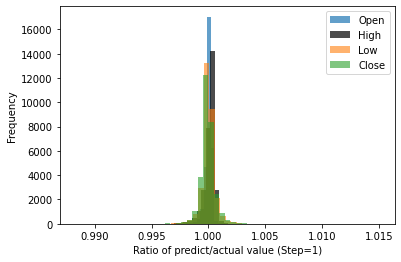

In [22]:
step=1
plt.hist(ohlc_pre[step, :, 0]/ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1]/ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2]/ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3]/ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Ratio of predict/actual value (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

[]

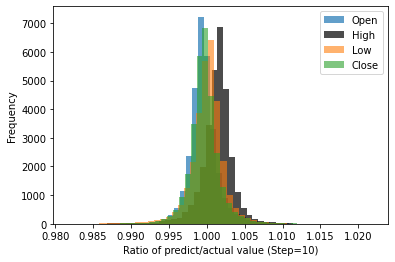

In [23]:
step=10
plt.hist(ohlc_pre[step, :, 0]/ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1]/ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2]/ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3]/ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Ratio of predict/actual value (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

In [24]:
print("==============Mean============")
print("Open", np.mean(ohlc_pre[:, :, 0]/ohlc_ans[:, :, 0], axis=1))
print("High", np.mean(ohlc_pre[:, :, 1]/ohlc_ans[:, :, 1], axis=1))
print("Low", np.mean(ohlc_pre[:, :, 2]/ohlc_ans[:, :, 2], axis=1))
print("Close", np.mean(ohlc_pre[:, :, 3]/ohlc_ans[:, :, 3], axis=1))

print("==============Var============")
print("Open", np.var(ohlc_pre[:, :, 0]/ohlc_ans[:, :, 0], axis=1))
print("High", np.var(ohlc_pre[:, :, 1]/ohlc_ans[:, :, 1], axis=1))
print("Low", np.var(ohlc_pre[:, :, 2]/ohlc_ans[:, :, 2], axis=1))
print("Close", np.var(ohlc_pre[:, :, 3]/ohlc_ans[:, :, 3], axis=1))

==============Mean============
Open [1.         1.0000491  1.00004847 1.00003229 1.00001672 0.99995379
 0.99990656 0.99981213 0.99972967 0.9996444  0.99959578]
High [1.         1.00009173 1.00021433 1.0003571  1.00050294 1.0006423
 1.0007966  1.00092957 1.00107054 1.00120608 1.00135692]
Low [1.         1.00003027 1.00004352 1.00004377 1.00004134 1.00004241
 1.00005349 1.00005793 1.0000651  1.00006899 1.00007486]
Close [1.         0.99994964 0.99991088 0.9998745  0.99983807 0.99981271
 0.9997777  0.99975998 0.99973703 0.99971735 0.99968548]
==============Var============
Open [0.00000000e+00 9.63960108e-08 6.00448670e-07 1.08603026e-06
 1.56206753e-06 2.02331491e-06 2.49318633e-06 2.97000372e-06
 3.43104269e-06 3.90469225e-06 4.37972700e-06]
High [0.00000000e+00 3.08642519e-07 7.73348865e-07 1.23662111e-06
 1.70301518e-06 2.19153770e-06 2.68242487e-06 3.18262785e-06
 3.69895253e-06 4.21150448e-06 4.74239620e-06]
Low [0.00000000e+00 3.65880707e-07 8.69729182e-07 1.38593285e-06
 1.90252711

[]

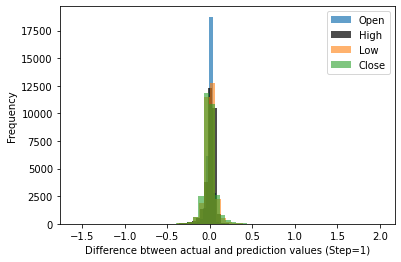

In [25]:
step=1
plt.hist(ohlc_pre[step, :, 0] - ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1] - ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2] - ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3] - ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

[]

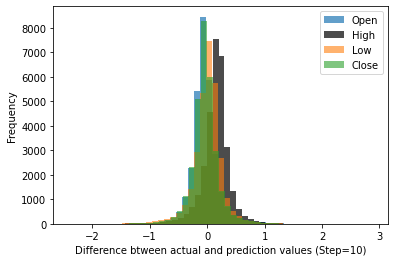

In [26]:
step=10
plt.hist(ohlc_pre[step, :, 0] - ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1] - ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2] - ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3] - ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

In [27]:
np.set_printoptions(precision=5)

print("==============Mean============")
print("Open", np.mean(ohlc_pre[:, :, 0]-ohlc_ans[:, :, 0], axis=1))
print("High", np.mean(ohlc_pre[:, :, 1]-ohlc_ans[:, :, 1], axis=1))
print("Low", np.mean(ohlc_pre[:, :, 2]-ohlc_ans[:, :, 2], axis=1))
print("Close", np.mean(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1))

print("==============Var============")
print("Open", np.var(ohlc_pre[:, :, 0]-ohlc_ans[:, :, 0], axis=1))
print("High", np.var(ohlc_pre[:, :, 1]-ohlc_ans[:, :, 1], axis=1))
print("Low", np.var(ohlc_pre[:, :, 2]-ohlc_ans[:, :, 2], axis=1))
print("Close", np.var(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1))

==============Mean============
Open [ 0.       0.00489  0.00552  0.00392  0.0023  -0.00476 -0.01002 -0.02067
 -0.02994 -0.03952 -0.04507]
High [0.      0.00954 0.02321 0.03912 0.05537 0.07088 0.08812 0.10293 0.11865
 0.13377 0.15057]
Low [0.      0.00306 0.00447 0.00429 0.0038  0.00369 0.00474 0.00504 0.00562
 0.00585 0.00628]
Close [ 0.      -0.0054  -0.00999 -0.01417 -0.01833 -0.0212  -0.0252  -0.02722
 -0.02984 -0.03209 -0.03569]
==============Var============
Open [0.      0.00132 0.00836 0.01513 0.02176 0.02821 0.03476 0.0414  0.04785
 0.05443 0.06104]
High [0.      0.00424 0.0106  0.01694 0.02334 0.03003 0.03678 0.04365 0.05074
 0.05779 0.06507]
Low [0.      0.00511 0.01209 0.01925 0.0264  0.03387 0.04156 0.04954 0.05776
 0.06585 0.07404]
Close [0.      0.00654 0.01222 0.01845 0.02446 0.03064 0.03681 0.04312 0.04941
 0.05563 0.06188]


ValueError: operands could not be broadcast together with shapes (0,) (11,) 

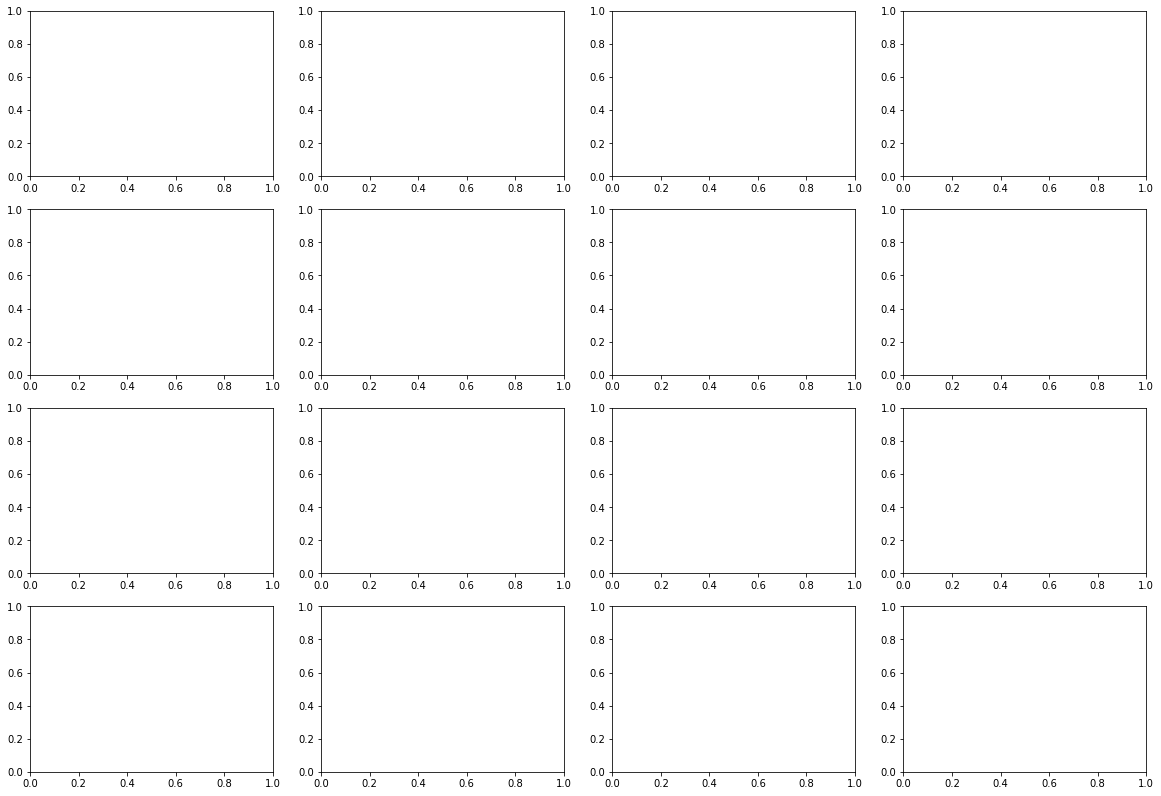

In [29]:
fig, axs = plt.subplots(4, 4, figsize=(20, 14))
close_mean = np.mean(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1)
close_var = np.var(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1)

total_length = observation_length + prediction_length
x = np.arange(total_length)



for i, ax in enumerate(axs.flat):
    index = ds.get_actual_index(i)
    original_ohlc = df[ohlc_column[3]].iloc[index: index + observation_length]
    pred_value = ohlc_pre[:, i, 3]
    pred_add_mean = pred_value + close_mean
    pred_upper = pred_add_mean + close_var
    pred_lower = pred_add_mean - close_var

    ax.fill_between(x[observation_length -1:], pred_value, pred_add_mean, color="orange", alpha=0.9)
    ax.fill_between(x[observation_length -1:], pred_lower, pred_upper, color="orange", alpha=0.3)
    ax.plot(x[:observation_length], original_ohlc, color="blue")
    ax.plot(x[observation_length-1:], ohlc_pre[:, i, 3], color="red")
    ax.plot(x[observation_length-1:], pred_value, color="green")
    
plt.show()